# Objective

Create Model Machine Learning that can help **Lenders** to choose who are qualified for a loan

## 1. Preparation

### 1.1 Import Libraries

In [2]:
#Import all library that will be usefull

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("white")
%matplotlib inline
# sns.set()

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

#For ignoring all warnings that will show up
import warnings
warnings.filterwarnings('ignore')

#For showing all columns and maximize width of columns
pd.pandas.set_option('display.max_colwidth', None)
pd.pandas.set_option('display.max_columns', None)

### 1.2 Load Datasets

In [3]:
#Import data which provided by lenders/loaners

main_data_train = pd.read_csv('app_train.csv') 
main_data_test = pd.read_csv('app_test.csv')
prev_loan_app = pd.read_csv('prev_app.csv')
payment_prev_loan = pd.read_csv('installment_payment.csv')
column_desc = pd.read_csv('columns_description.csv')

For main data, I will only focus on data train. For 2nd & 3rd table, I would do the merge since they're correlated

Now, I will show what the data looks like and the description for every features(columns)

In [4]:
df = main_data_train.copy()
print('Main Data')
display(df.head())

merge_data = pd.merge(prev_loan_app, payment_prev_loan, how= 'left', on=['LN_ID', 'SK_ID_PREV'])

prev_loan_payment = merge_data.copy()
print('\nPrevious loan Application with Payment Data')
display(prev_loan_payment.head())

Main Data


,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
0,201468,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,Secondary / secondary special,Married,With parents,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,0.572805,0.608276,NaN
1,264803,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,0.655600,0.684298,NaN
2,137208,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1,NaN,0.580687,0.749022
3,269220,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,Married,House / apartment,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,NaN,0.623740,0.710674
4,122096,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,0.175511,0.492994,0.085595



Previous loan Application with Payment Data


,Unnamed: 0_x,SK_ID_PREV,LN_ID,CONTRACT_TYPE,ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRICE,WEEKDAYS_APPLY,HOUR_APPLY,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,Unnamed: 0_y,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
0,0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Approved,-73,12.0,middle,365243.0,-42.0,-37.0,0.0,6520759.0,1.0,-42.0,-42.0,17284.275,17284.275
1,3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0,108784.0,8.0,-272.0,-281.0,47041.335,47041.335
2,3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0,275973.0,7.0,-302.0,-305.0,47041.335,47041.335
3,3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0,811980.0,11.0,-182.0,-197.0,92720.025,92720.025
4,3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0,1505617.0,10.0,-212.0,-214.0,47041.335,47041.335


### 1.3 Check NULL values

In [5]:
df_null = pd.DataFrame(data = [df.isna().sum(), round(df.isna().sum()/df.shape[0]*100, 3)], index=['Null values', 'Null values (%)']).T.style.background_gradient(cmap='YlOrRd')
# df_null['Null values'] = df_null['Null values'].astype('int')
df_null

,Null values,Null values (%)
Unnamed: 0,0.000000,0.000000
LN_ID,0.000000,0.000000
TARGET,0.000000,0.000000
CONTRACT_TYPE,0.000000,0.000000
GENDER,0.000000,0.000000
NUM_CHILDREN,0.000000,0.000000
INCOME,0.000000,0.000000
APPROVED_CREDIT,0.000000,0.000000
ANNUITY,1.000000,0.002000
PRICE,62.000000,0.101000


In [6]:
prev_loan_payment_null = pd.DataFrame(data = [prev_loan_payment.isna().sum(), round(prev_loan_payment.isna().sum()/prev_loan_payment.shape[0]*100, 3)], index=['Null values', 'Null values (%)']).T.style.background_gradient(cmap='YlOrRd')
#loan_app_null['Null values'] = loan_app_null['Null values'].astype('int')
prev_loan_payment_null

,Null values,Null values (%)
Unnamed: 0_x,0.000000,0.000000
SK_ID_PREV,0.000000,0.000000
LN_ID,0.000000,0.000000
CONTRACT_TYPE,0.000000,0.000000
ANNUITY,76609.000000,2.767000
APPLICATION,0.000000,0.000000
APPROVED_CREDIT,0.000000,0.000000
AMT_DOWN_PAYMENT,1426676.000000,51.521000
PRICE,570191.000000,20.591000
WEEKDAYS_APPLY,0.000000,0.000000


- For `df`, we can see that only few features have serious null values
- For `prev_loan_payment`, compare to `df` this table has so many null value in some features and just a few in other features

And we will need to analyze later to decide whether to drop or do some imputation for all of those **null values**

### 1.4 Check Duplicates Data

In [7]:
print(f'df train data has {df.duplicated().sum()} duplicated data')
print(f'prev_loan_payment data has {prev_loan_payment.duplicated().sum()} duplicated data')
#print(f'df train data has {payment_app.duplicated().sum()} duplicated data')

df train data has 0 duplicated data
prev_loan_payment data has 0 duplicated data


Since there are no duplicates data for these 3 tables, we good to go for next step

### 1.5 Dataset Information

#### Main data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         61503 non-null  int64  
 1   LN_ID              61503 non-null  int64  
 2   TARGET             61503 non-null  int64  
 3   CONTRACT_TYPE      61503 non-null  object 
 4   GENDER             61503 non-null  object 
 5   NUM_CHILDREN       61503 non-null  int64  
 6   INCOME             61503 non-null  float64
 7   APPROVED_CREDIT    61503 non-null  float64
 8   ANNUITY            61502 non-null  float64
 9   PRICE              61441 non-null  float64
 10  INCOME_TYPE        61503 non-null  object 
 11  EDUCATION          61503 non-null  object 
 12  FAMILY_STATUS      61503 non-null  object 
 13  HOUSING_TYPE       61503 non-null  object 
 14  DAYS_AGE           61503 non-null  int64  
 15  DAYS_WORK          61503 non-null  int64  
 16  DAYS_REGISTRATION  615

In [9]:
disc_feat_df = [feature for feature in df.columns if df[feature].dtypes == 'int64']
cont_feat_df = [feature for feature in df.columns if df[feature].dtypes == 'float']
cat_feat_df = [feature for feature in df.columns if df[feature].dtypes == 'O']

In [10]:
print(f'Main Data : {df.shape[0]} rows & {df.shape[1]} features')
print(f'Number of discrete features = {len(disc_feat_df)}')
print(f'Number of continous features = {len(cont_feat_df)}')
print(f'Number of categorical features = {len(cat_feat_df)}')

Main Data : 61503 rows & 24 features
Number of discrete features = 8
Number of continous features = 8
Number of categorical features = 8


#### Previous loan application with Payment

In [11]:
prev_loan_payment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2769135 entries, 0 to 2769134
Data columns (total 25 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0_x               int64  
 1   SK_ID_PREV                 int64  
 2   LN_ID                      int64  
 3   CONTRACT_TYPE              object 
 4   ANNUITY                    float64
 5   APPLICATION                float64
 6   APPROVED_CREDIT            float64
 7   AMT_DOWN_PAYMENT           float64
 8   PRICE                      float64
 9   WEEKDAYS_APPLY             object 
 10  HOUR_APPLY                 int64  
 11  CONTRACT_STATUS            object 
 12  DAYS_DECISION              int64  
 13  TERM_PAYMENT               float64
 14  YIELD_GROUP                object 
 15  FIRST_DRAW                 float64
 16  FIRST_DUE                  float64
 17  TERMINATION                float64
 18  NFLAG_INSURED_ON_APPROVAL  float64
 19  Unnamed: 0_y               float64
 20  IN

In [12]:
disc_prev_pay = [feature for feature in prev_loan_payment.columns if prev_loan_payment[feature].dtypes == 'int64']
cont_prev_loan = [feature for feature in prev_loan_payment.columns if prev_loan_payment[feature].dtypes == 'float']
cat_prev_loan = [feature for feature in prev_loan_payment.columns if prev_loan_payment[feature].dtypes == 'O']

In [13]:
print(f'Main Data : {prev_loan_payment.shape[0]} rows & {prev_loan_payment.shape[1]} features')
print(f'Number of discrete features in prev_loan_payment = {len(disc_prev_pay)}')
print(f'Number of continous features in prev_loan_payment = {len(cont_prev_loan)}')
print(f'Number of categorical features in prev_loan_payment = {len(cat_prev_loan)}')

Main Data : 2769135 rows & 25 features
Number of discrete features in prev_loan_payment = 5
Number of continous features in prev_loan_payment = 16
Number of categorical features in prev_loan_payment = 4


#### Summary

From 2 tables which provided from loaners, I got information like this:
> Rows :
    - Main data : 61.503 records
    - Previoius loan application with Payment : 350.712 records
> Numerical Data:
    - Discrete : 17 Features
    - Continues : 22 Features
> Categorical Data: 
    - Nominal : 7 Features (Categorical data without rank/orders)
    - Ordinal : 5 Features (Categorical data with rank/orders)

## 2. Exploratory Data Analysis (EDA)

### 2.1 Preparing for visualization

Since `Unnamed` features will not be used, I'll drop it here before doing EDA

In [14]:
#Since `Unnamed` Features are not used, I'll Drop it on both data
df = df.drop(columns='Unnamed: 0')
prev_loan_payment = prev_loan_payment.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])

In [15]:
# For target Data
def target_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    df[var].value_counts().plot(kind="pie", explode=[0.1 for x in data[var].dropna().unique()], colors=['#F38181', '#FCE38A'], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{var} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=var, data=df, ax=ax[1], palette= ['#F38181', '#FCE38A'])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{var} Bar Chart")
    plt.show()
    
#For categorical Data
def cat_dist(data, var):
    fig, ax = plt.subplots(nrows= 2, ncols= 4, figsize=(25, 15))
    count = sns.countplot(x=var, data=df, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{var} Bar Chart")
    plt.show()
    
#For numerical Data
def num_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(data=data, x=var, kde=True, ax=ax[0], bins=30, palette= ['#FF5959'])
    sns.boxplot(data=data, x=var, ax=ax[1], palette= ['#676FA3'])
    ax[0].set_title(f"{var} Distribution Histogram")
    ax[1].set_title(f"{var} Distribution Boxplot")

    plt.show()

##### Main Data

In [16]:
cat_var = [feature for feature in df.columns if df[feature].dtypes == 'O']
df_cat = df[cat_var]
num_var = [num for num in df.columns if df[num].dtype in ['int64', 'float64']]
df_num = df[num_var]

#Since we don't need LN_ID because it's unique data and Target data which I've shown above so I'll drop it this features
df_num = df_num.drop(columns=['LN_ID', 'TARGET'])

Like I mention before that I merge `Previous Loan Application` and `Past Payment` table to get more information compared if we do EDA one by one each table

With merged and I use **Left JOIN** it means I get data where debtors are applying a loan and status either their application was `Accept`, `Canceled`, `Refused`, or `Unused Offer` and it's helpfull to track the behaviors of next debtors to see are they qualified or not to for loan

And It's ok if there are so many **NULL** values, it means that there are not transaction happen since they are **not qualified** for loan

In [17]:
prev_loan_payment['CONTRACT_STATUS'].value_counts()

Approved        2638110
Canceled          64590
Refused           60795
Unused offer       5640
Name: CONTRACT_STATUS, dtype: int64

As you can see total of debtors who **aren't qualified** was around 131K people, that's why you gonna see missing values close to that number

##### Previous loan application with Payment

In [18]:
cat_prev_payment = [feature for feature in prev_loan_payment.columns if prev_loan_payment[feature].dtypes == 'O']
prev_payment_cat = prev_loan_payment[cat_prev_payment]
num_prev_payment = [num for num in prev_loan_payment.columns if prev_loan_payment[num].dtypes in ['int64', 'float64']]
prev_payment_num = prev_loan_payment[num_prev_payment]

#Since we don't need LN_ID because it's unique data  which I've shown above so I'll drop it this features
prev_payment_num = prev_payment_num.drop(columns=['LN_ID', 'SK_ID_PREV'])

### 2.2 Target Distribution

First I will show how `target data` distribution look like

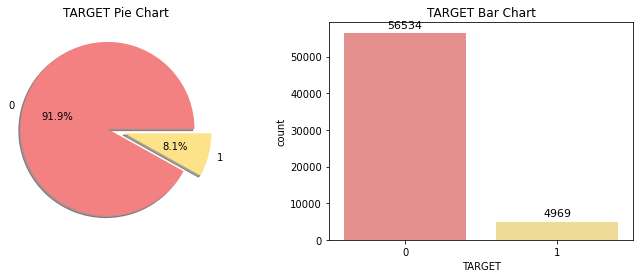

In [19]:
target_dist(df, 'TARGET')

Urfortunately as this graph shown that target we are dealing with was **Imbalance**, for this reason we will analyze the features which cause this to happen **but** one thing for sure from this graph I would say that we not gonna use `accuracy` metrix for the evaluation of our model 

### 2.3 Feature Distribution

#### 2.3.1 Numerical - Main Data

In [20]:
year = ['DAYS_AGE', 'DAYS_WORK', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE']

for i in year:
    df[i] = abs(df[i]//365)

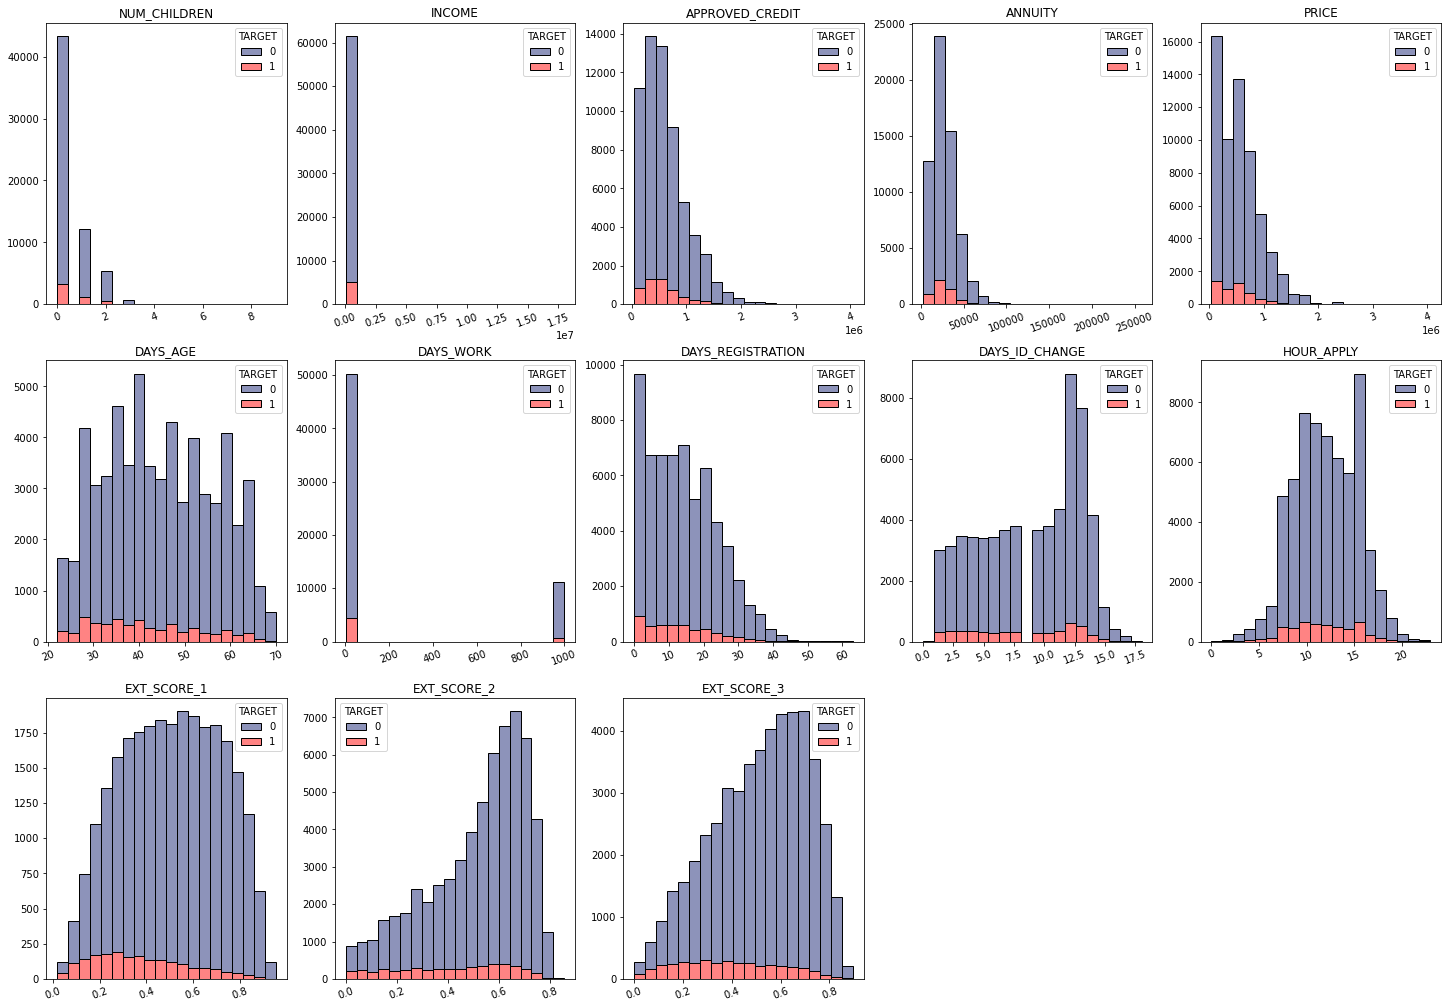

In [21]:
fig = plt.figure(figsize = (25, 30))

i = 1
for n in df_num.columns:
    plt.subplot(5, 5, i)
    ax = sns.histplot(x = df[n], hue = df['TARGET'], palette = ['#676FA3', '#FF5959'], bins= 20, multiple='stack')
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(n), loc = 'center')
    plt.xticks(rotation = 20, fontsize = 10)
    i += 1

### Insight:
- From these subplots we can get conclusion that debtors with **less number of children** has a chance to causing **losses** to loaner/lenders
- For `Income`, `Approved credit`, `Annuity`, `Price`, I'd like to analyze more since they look like have outliers
- Only a few debtors who are wealthy enough to become a debtors, probably they need loans for an investment or it's just an error input by human
- `Approved Credit` are the limit of loan amount and `Price` is the amount of loan that loaner/lender give it to debtors, it means probably both of these features are redundant which means 1 of these features can be dropped
- It seems like there's a slightly impact for each `EXT_SCORE`:
    > for `1` the probability for debtors who did the payment more than X days was increasing between **0.2 - 0.4**
    
    > for `2`, I'm not really sure that this graph would give same information like `1`. Because the probability while at **0.5** is significantly increasing with debtors who didn't make the payment
    
    > for `3`, I would say that this parameter somewhat did the same thing like `EXC_SCORE_1`. Because It's increasing between **0.2 - 0.4** compare to debtors at same point who didn't returns the loan

#### 2.3.2 Numerical - Previous loan application with Payment

`CONTRACT STATUS` features is key features where I can get valuable information which debtors have

In [22]:
year_2 = ['DAYS_DECISION', 'FIRST_DRAW', 'FIRST_DUE', 'INST_DAYS', 'PAY_DAYS']

for i in year_2:
    prev_loan_payment[i] = abs(prev_loan_payment[i]//365)

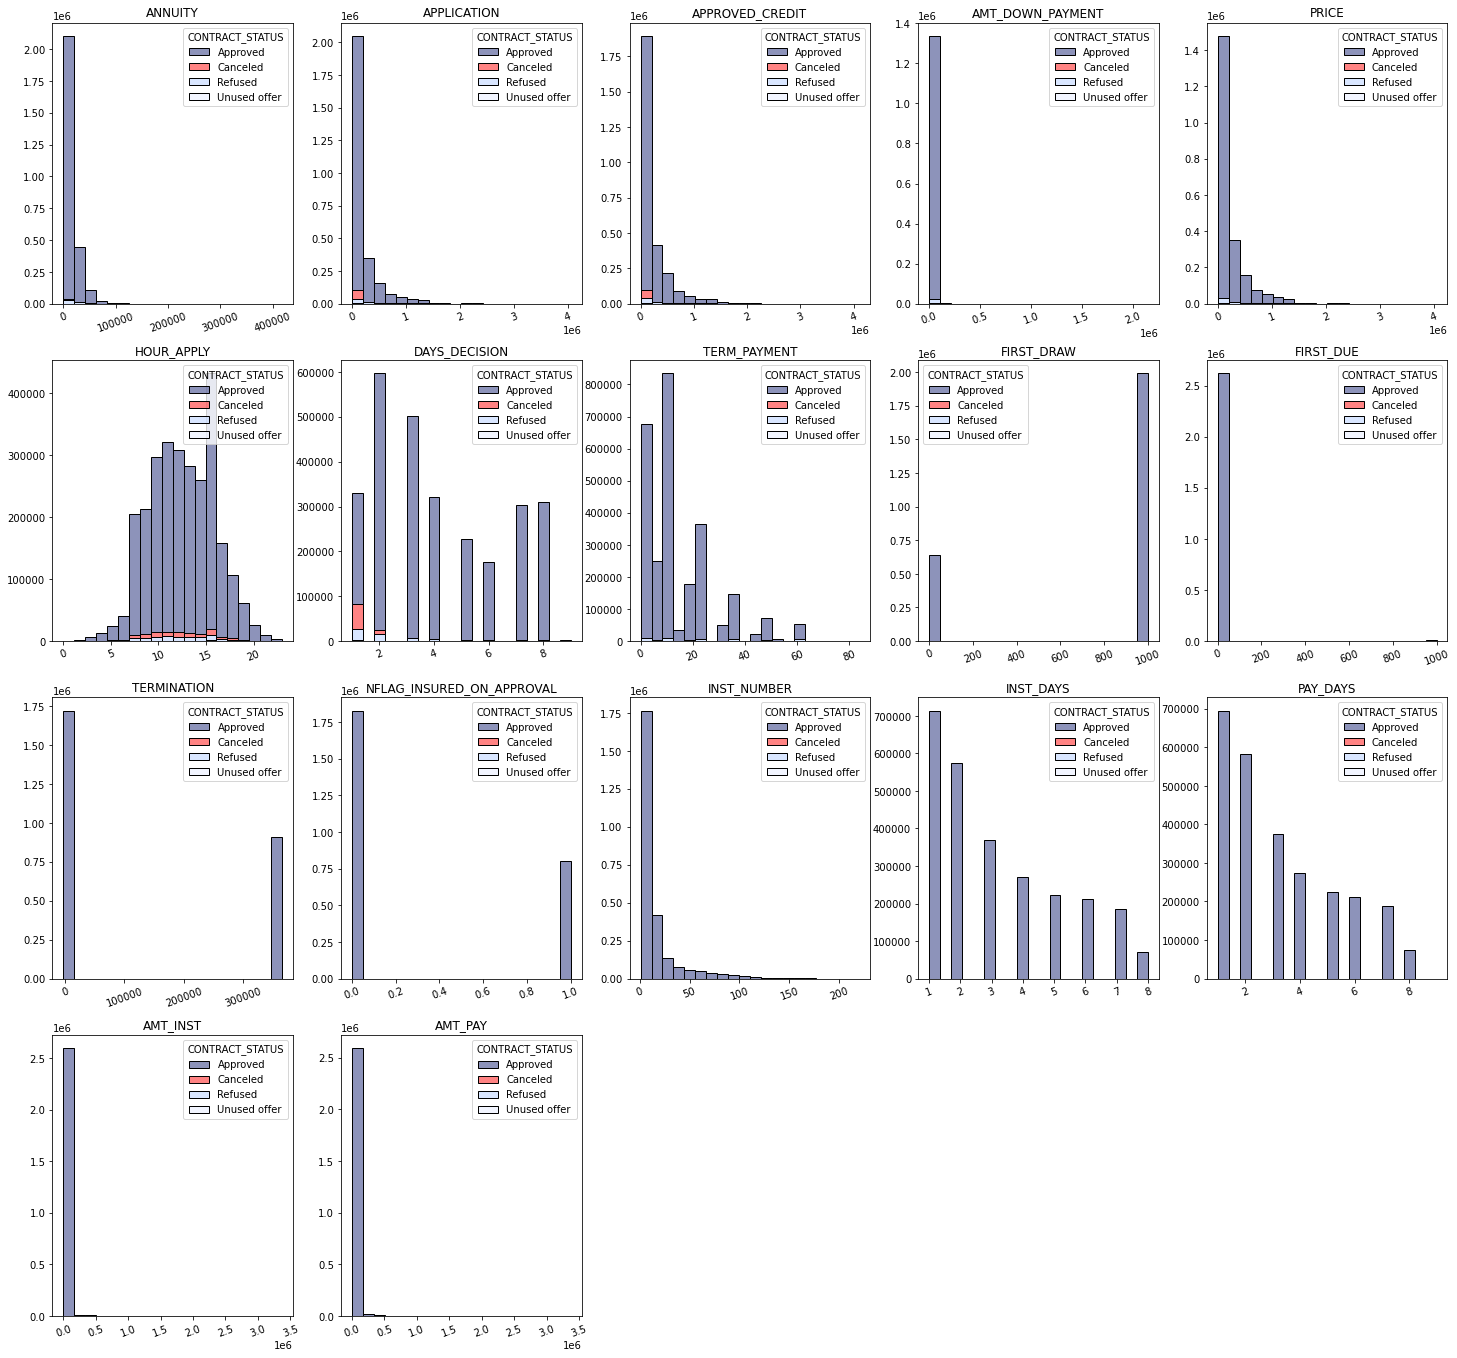

In [23]:
fig = plt.figure(figsize = (25, 30))

i = 1
for n in prev_payment_num.columns:
    plt.subplot(5, 5, i)
    ax = sns.histplot(x = prev_loan_payment[n], hue = prev_loan_payment['CONTRACT_STATUS'], 
                      palette=['#676FA3', '#FF5959', '#CDDEFF', '#EEF2FF'], bins= 20, multiple='stack')
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(n), loc = 'center')
    plt.xticks(rotation = 20, fontsize = 10)
    i += 1

From this graph we can say that most application are approved, just a few of features that give visualize the behaviors of debtors that are **not qualified**, also for this table it seems like there are so many outliers since it would be problem for the accuracy of the model if we not clear them

In [24]:
prev_loan_payment[prev_loan_payment['PRICE'].isnull()].sample(20)

,SK_ID_PREV,LN_ID,CONTRACT_TYPE,ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRICE,WEEKDAYS_APPLY,HOUR_APPLY,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
237094,1395708,354169,Revolving loans,11250.0,0.0,225000.0,NaN,NaN,THURSDAY,17,Approved,3,0.0,NA1,3.0,3.0,365243.0,0.0,39.0,1.0,1.0,4157.145,4157.145
2219889,1112642,261207,Revolving loans,22500.0,0.0,450000.0,NaN,NaN,TUESDAY,16,Approved,3,0.0,NA1,2.0,2.0,365243.0,0.0,9.0,2.0,2.0,31500.000,31500.000
2614091,1188703,156133,Revolving loans,9000.0,0.0,180000.0,NaN,NaN,FRIDAY,11,Approved,7,0.0,NA1,7.0,7.0,365243.0,0.0,10.0,6.0,6.0,4500.000,4500.000
779522,2249323,383249,Revolving loans,6300.0,0.0,90000.0,NaN,NaN,TUESDAY,17,Approved,6,0.0,NA1,6.0,6.0,365243.0,0.0,56.0,2.0,2.0,25.785,25.785
2269369,1333138,154388,Revolving loans,3375.0,0.0,67500.0,NaN,NaN,SUNDAY,12,Approved,8,0.0,NA1,8.0,8.0,365243.0,0.0,99.0,1.0,1.0,435.915,435.915
1923916,2000040,297356,Revolving loans,4500.0,0.0,90000.0,NaN,NaN,WEDNESDAY,8,Approved,7,0.0,NA1,7.0,6.0,-99.0,0.0,56.0,2.0,2.0,130.500,130.500
2141921,2480630,395031,Revolving loans,6750.0,0.0,135000.0,NaN,NaN,TUESDAY,14,Approved,7,0.0,NA1,7.0,7.0,365243.0,0.0,64.0,4.0,4.0,15750.000,15750.000
2457563,1469342,357816,Revolving loans,4500.0,0.0,90000.0,NaN,NaN,SUNDAY,13,Approved,7,0.0,NA1,7.0,7.0,-134.0,0.0,12.0,6.0,6.0,4500.000,4500.000
2192736,2817381,216247,Revolving loans,3375.0,0.0,67500.0,NaN,NaN,WEDNESDAY,9,Approved,8,0.0,NA1,8.0,8.0,365243.0,0.0,69.0,4.0,4.0,3375.000,3375.000
233915,2366413,352860,Revolving loans,22500.0,0.0,450000.0,NaN,NaN,FRIDAY,6,Approved,4,0.0,NA1,1000.0,1000.0,365243.0,0.0,NaN,NaN,NaN,NaN,NaN


#### 2.3.3 Categorical - Main Data

Since `Organization Type` have so many label and it will not give any insight (because we can't see any proper graph) then I will group the label by their functions

In [25]:
Public_servant = ['Government', 'Military', 'Emergency', 'Police', 'Security', 'Bank', 'Postal', 'Security Ministries',
                 'Legal Services']
Education = ['Kindergarten', 'School', 'University']
Business = ['Business Entity Type 3', 'Business Entity Type 2', 'Business Entity Type 1']
Industry = ['Industry: type 1', 'Industry: type 2', 'Industry: type 3', 'Industry: type 4', 'Industry: type 5',
             'Industry: type 6', 'Industry: type 7', 'Industry: type 8', 'Industry: type 9', 'Industry: type 10',
             'Industry: type 11',  'Industry: type 12', 'Industry: type 13']
Trade = ['Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4', 'Trade: type 5', 'Trade: type 6',
         'Trade: type 7', 'Realtor']
Transport = ['Transport: type 1', 'Transport: type 2', 'Transport: type 3', 'Transport: type 4', 'Mobile']
Property = ['Construction', 'Housing', 'Hotel']
Service = ['Religion', 'Cleaning', 'Culture', 'Advertising', 'Insurance', 'Telecom', 'Services', 'Restaurant', 
           'Electricity', 'Medicine']
Other = ['Other', 'Agriculture']

In [26]:
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace(Public_servant, 'Public Servant')
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace(Education, 'Education')
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace(Business, 'Business')
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace(Industry, 'Industry')
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace(Trade, 'Trade')
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace(Transport, 'Transport')
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace(Property, 'Property')
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace(Service, 'Service')
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace(Other, 'Others')
df_cat['ORGANIZATION_TYPE'] = df_cat['ORGANIZATION_TYPE'].replace('NA1', 'Unemployment')

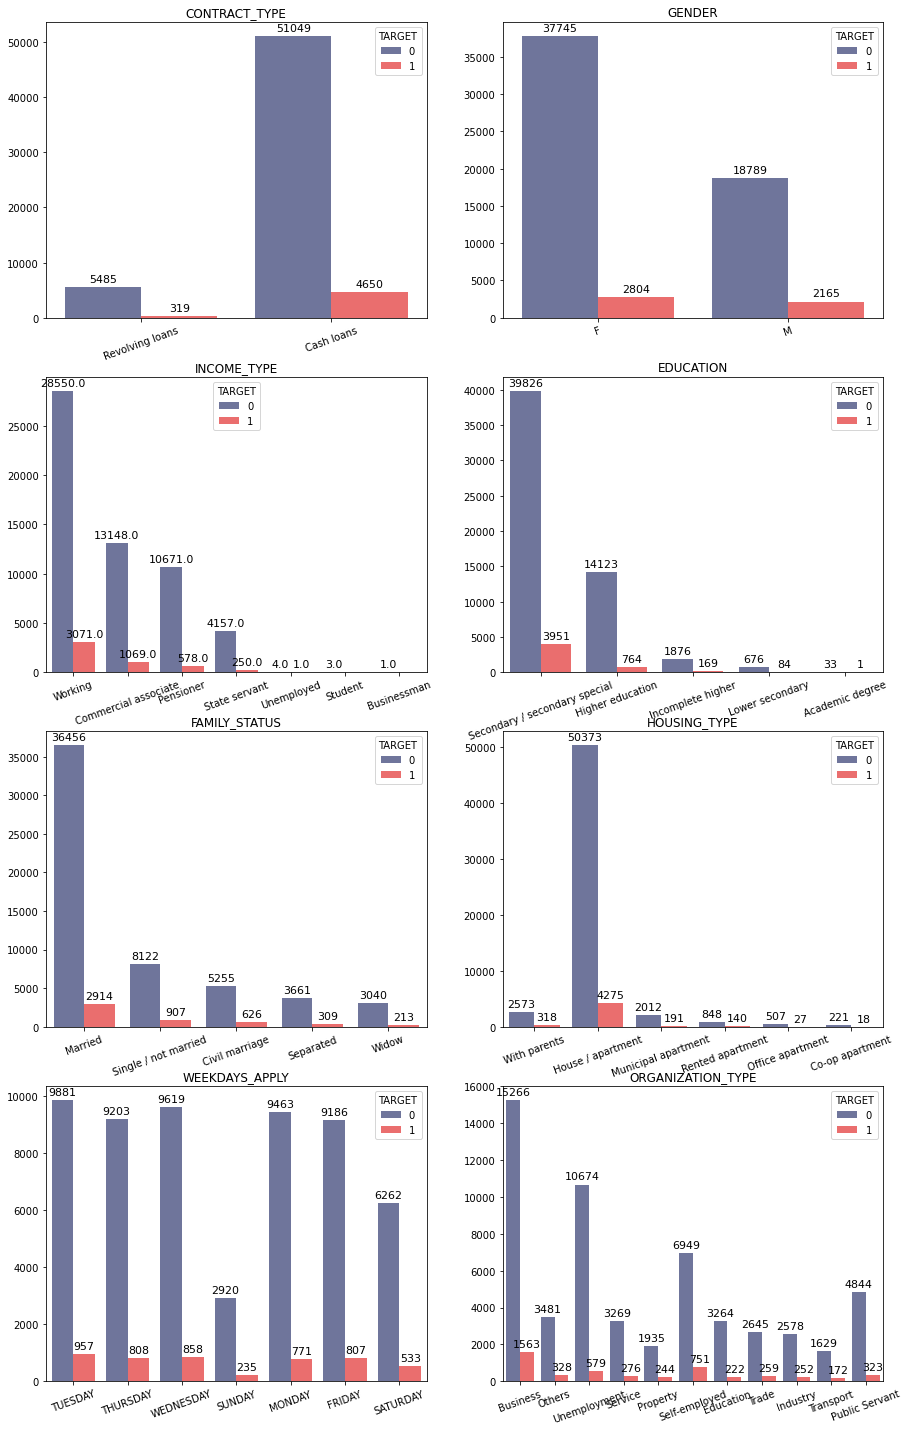

In [27]:
fig = plt.figure(figsize = (15, 25))

i = 1
for c in cat_feat_df:
    plt.subplot(4, 2, i)
    ax = sns.countplot(data = df_cat, x = df_cat[c], hue = df['TARGET'], palette = ['#676FA3', '#FF5959'])
    ax.set(xlabel = None, ylabel = None)
    for bar in ax.patches:
        ax.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    plt.title(str(c), loc='center')
    plt.xticks(rotation = 20, fontsize = 10)
    i += 1

### Insight:
- Most of the debtors are going to take the **cash loan** instead of revolving, since it's more fulfilled for people's need in a specific time
- Most of the debtors are came from **married women living in their homes** who clearly have more urgent problems to take a loan as they are the ones holding the finances in the household and well known about family needs
- And of course **sunday** was not the best day to take a loan since maybe lenders are not available at weekend
- An interesting insight that I found was that people with the status of **Unemployed** were in second place in taking out loans, right behind those debtors with **Business** status
- But, compare to **Business** debtors which take loans, people who **Self-employed** have slighty better percentage for paying the loans (Business - 10.23%) (Self-Employed - 10.8%)

#### 2.3.4 Categorical - Previous loan application with Payment

In [28]:
#I should drop Contract Status features since it will be the dividers
prev_payment_cat = prev_payment_cat.drop(columns= 'CONTRACT_STATUS')

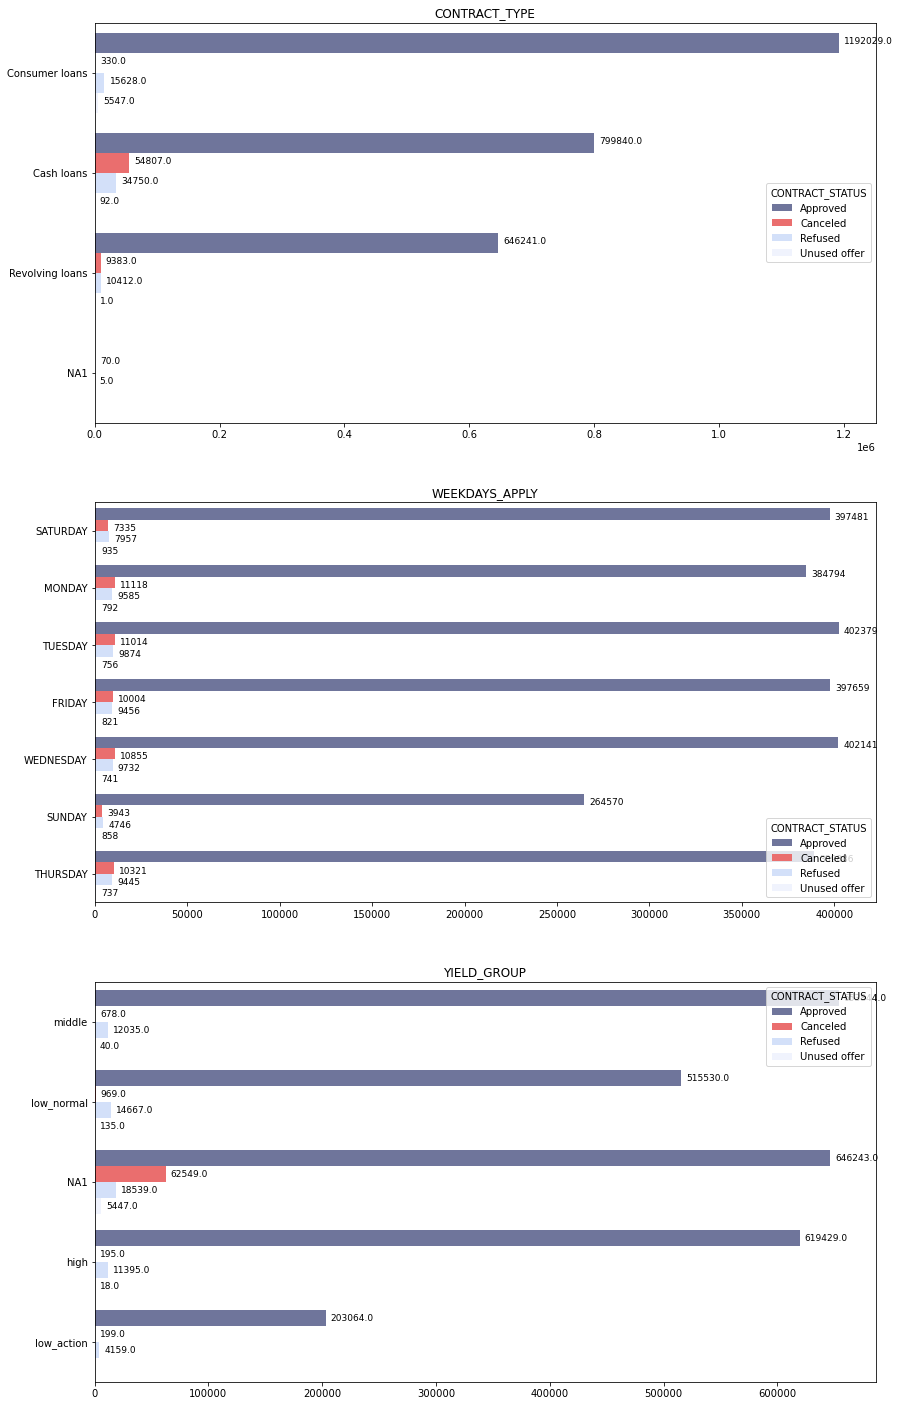

In [29]:
fig = plt.figure(figsize = (14, 25))

i = 1
for c in prev_payment_cat.columns:
    plt.subplot(3, 1, i)
    ax = sns.countplot(data = prev_loan_payment, y = prev_loan_payment[c], hue = prev_loan_payment['CONTRACT_STATUS'],
                        palette = ['#676FA3', '#FF5959', '#CDDEFF', '#EEF2FF'])
    ax.set(xlabel = None, ylabel = None)
    for p in ax.patches:
        ax.annotate(format(p.get_width()),
                    ((p.get_x() + p.get_width()), p.get_y()), 
                    xytext=(5, -11),fontsize=9,textcoords='offset points')
    plt.title(str(c), loc='center')
    #plt.xticks(rotation = 20, fontsize = 10)
    i += 1

### Insight:

- Compare to other days of apply loan, `Monday` is the only day which have the least `Approved` application followed with highest `Canceled` application
- In `Contract Type`, Many lenders/loaners `Canceled/Refuse` for `Cash Loans` appliacation
- `NA1` which I still don't know what is it, but it has the highest `Canceled` application on `Yield Group`

## 3. Pre-Processing (Feature Engineering)

### 3.1 Handling Outliers

It's best to remove **outliers**, but on the other hand there are some condition where we don't need to handle these outliers and it is called as **true/natural outliers**. Something like population, Time series, and currency/transaction probably are the represent of the natural outliers as it seems in this case

So for this case, I didn't perform or clear the **Outliers**

### 3.2 Handling Missing Value

First, I'm gonna handle missing values on Main data

In [30]:
df.isnull().sum()

LN_ID                    0
TARGET                   0
CONTRACT_TYPE            0
GENDER                   0
NUM_CHILDREN             0
INCOME                   0
APPROVED_CREDIT          0
ANNUITY                  1
PRICE                   62
INCOME_TYPE              0
EDUCATION                0
FAMILY_STATUS            0
HOUSING_TYPE             0
DAYS_AGE                 0
DAYS_WORK                0
DAYS_REGISTRATION        0
DAYS_ID_CHANGE           0
WEEKDAYS_APPLY           0
HOUR_APPLY               0
ORGANIZATION_TYPE        0
EXT_SCORE_1          34845
EXT_SCORE_2            134
EXT_SCORE_3          12239
dtype: int64

- For missing values which are below 1% of data, I just gonna drop them which mean I'll drop the null values of `ANNUITY`, `PRICE`, `EXT_SCORE_2`
- For `EXT_SCORE_1` are normalize score and it has more than 50% of missing values, I can't do the imputation to this feature so I'm just gonna **drop this feature**
- For `EXT_SCORE_3` since all these scores are score from external data source which means not related to any other features in this data, and it has almost 20% data, I'm gonna handle this feature with **drop rows** with null values

In [31]:
df = df.dropna(subset=['ANNUITY', 'PRICE', 'EXT_SCORE_2'])
df = df.drop(columns='EXT_SCORE_1')
df = df.dropna(subset=['EXT_SCORE_3'])

Next, for Previous Loan Application with Payments

- For `AMT_DOWN_PAYMENT` since it has so much missing value and as I get information from EDA that it has correlation with `CONTRACT_TYPE`, I will drop the `AMT_DOWN_PAYMENT` and I will change the value of `CONTRACT_TYPE` into 2 value only
- `PRICE` has strong correlation with `APPLICATION`, it means I will change the null value to 0 when everytime `APPLICATION` is **0** (since application doesn't has null)

In [32]:
prev_loan_payment = prev_loan_payment.drop(columns='AMT_DOWN_PAYMENT')
prev_loan_payment['CONTRACT_TYPE'] = prev_loan_payment['CONTRACT_TYPE'].replace(
    ['Cash loans', 'Revolving loans', 'NA1'], 'Other loans') 

In [33]:
prev_loan_payment['PRICE'] = prev_loan_payment[prev_loan_payment['APPLICATION'] == 0.0].fillna(0)

In [34]:
prev_loan_payment['PRICE'] = np.where(((prev_loan_payment['PRICE'].isnull()) & (prev_loan_payment['APPLICATION'].notnull())),
                                     prev_loan_payment['PRICE'].fillna(0), prev_loan_payment['PRICE'])

Next, we clear missing values on `ANNUITY` and `TERM_PAYMENT` since they have same missing values amount 

In [35]:
prev_loan_payment[(prev_loan_payment['ANNUITY'].isnull()) & (prev_loan_payment['TERM_PAYMENT'].isnull())].shape

(76609, 22)

We see that these 2 Features are correlated, since if one of them are missing then it will affect to each other. So now we need to find another features that correlated with them which still have information why they are have no value

In [36]:
prev_loan_payment[(prev_loan_payment['ANNUITY'].isnull()) & (prev_loan_payment['CONTRACT_STATUS'] == 'Approved')]

,SK_ID_PREV,LN_ID,CONTRACT_TYPE,ANNUITY,APPLICATION,APPROVED_CREDIT,PRICE,WEEKDAYS_APPLY,HOUR_APPLY,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
383090,1899883,306602,Other loans,NaN,202500.0,202500.0,0,MONDAY,10,Approved,2,NaN,NA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1792865,2317108,448308,Other loans,NaN,675000.0,675000.0,0,WEDNESDAY,12,Approved,1,NaN,NA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So as you can see there were **only 2 rows over 2.7 M records** where `ANNUITY` is null and `CONTRACT_STATUS` were approved. It make sense that There will be no charge to debtors if their **application not approved**.

So for those 2 rows, we are gonna drop it and for the rest of null data on `ANNUITY` and `TERM_PAYMENT` we gonna fill with `0` since it means there are 0 charge for debtors who **their application was not approved**

In [37]:
prev_loan_payment= prev_loan_payment.drop(prev_loan_payment[(prev_loan_payment['ANNUITY'].isnull()) 
                                                            & (prev_loan_payment['CONTRACT_STATUS'] == 'Approved')].index, axis=0)

In [38]:
prev_loan_payment[['ANNUITY', 'TERM_PAYMENT']] = prev_loan_payment[['ANNUITY', 'TERM_PAYMENT']].fillna(0)

For the rest of the missing value, after doing EDA it will make sense if the application was **not approved** and there would be no any next charge of transactions. So I'll just **turn them to 0**

In [39]:
prev_loan_payment = prev_loan_payment.fillna(0)
prev_loan_payment.isnull().sum()

SK_ID_PREV                   0
LN_ID                        0
CONTRACT_TYPE                0
ANNUITY                      0
APPLICATION                  0
APPROVED_CREDIT              0
PRICE                        0
WEEKDAYS_APPLY               0
HOUR_APPLY                   0
CONTRACT_STATUS              0
DAYS_DECISION                0
TERM_PAYMENT                 0
YIELD_GROUP                  0
FIRST_DRAW                   0
FIRST_DUE                    0
TERMINATION                  0
NFLAG_INSURED_ON_APPROVAL    0
INST_NUMBER                  0
INST_DAYS                    0
PAY_DAYS                     0
AMT_INST                     0
AMT_PAY                      0
dtype: int64

### 3.3 Merge Table

####  Preparation

Before I turn categorical features into numerical, I'd like to group some of them. For example:

- In main data: `FAMILY_STATUS`, I'd like to merge `Marriage` value with `Civil Marriage`
- In Previous Loan Application with Payment : `CONTRACT_STATUS`, I'd like to group them in to 2 categories. Only `Approved` and `Not Approved`

In [40]:
df['FAMILY_STATUS'] = df['FAMILY_STATUS'].replace('Civil marriage', 'Married')
prev_loan_payment['CONTRACT_STATUS'] = prev_loan_payment['CONTRACT_STATUS'].replace(['Approved', 'Canceled', 'Refused', 'Unused offer' ], 
                                                                                    ['Approved', 'Not Approved', 'Not Approved', 'Not Approved'])
# prev_loan_payment['CONTRACT_STATUS'] = prev_loan_payment['CONTRACT_STATUS'].map({'Approved' : 'Approved',
#                                                                              'Canceled': 'Not Approved', 
#                                                                              'Refused': 'Not Approved', 
#                                                                             'Unused offer': 'Not Approved'})

I'll divide first categorical features into 2 types: Numerical & Ordinal

And mapping `Organization Type` value since we did it before on new variable only for EDA

In [41]:
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(Public_servant, 'Public Servant')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(Education, 'Education')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(Business, 'Business')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(Industry, 'Industry')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(Trade, 'Trade')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(Transport, 'Transport')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(Property, 'Property')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(Service, 'Service')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(Other, 'Others')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace('NA1', 'Unemployment')

I'm gonna merge some important features since the `Main Data` would be one only data to do the modelling

In [42]:
prev_loan_payment.head()

,SK_ID_PREV,LN_ID,CONTRACT_TYPE,ANNUITY,APPLICATION,APPROVED_CREDIT,PRICE,WEEKDAYS_APPLY,HOUR_APPLY,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,SATURDAY,15,Approved,1,12.0,middle,1000.0,1.0,-37.0,0.0,1.0,1.0,1.0,17284.275,17284.275
1,2819243,176158,Other loans,47041.335,450000.0,470790.0,0.0,MONDAY,7,Approved,2,12.0,middle,1000.0,2.0,-177.0,1.0,8.0,1.0,1.0,47041.335,47041.335
2,2819243,176158,Other loans,47041.335,450000.0,470790.0,0.0,MONDAY,7,Approved,2,12.0,middle,1000.0,2.0,-177.0,1.0,7.0,1.0,1.0,47041.335,47041.335
3,2819243,176158,Other loans,47041.335,450000.0,470790.0,0.0,MONDAY,7,Approved,2,12.0,middle,1000.0,2.0,-177.0,1.0,11.0,1.0,1.0,92720.025,92720.025
4,2819243,176158,Other loans,47041.335,450000.0,470790.0,0.0,MONDAY,7,Approved,2,12.0,middle,1000.0,2.0,-177.0,1.0,10.0,1.0,1.0,47041.335,47041.335


In [43]:
prev_loan_payment = pd.get_dummies(prev_loan_payment, columns = ['CONTRACT_STATUS'], drop_first=True)
prev_loan_payment['CONTRACT_STATUS_Not Approved'].value_counts()

0    2638108
1     131025
Name: CONTRACT_STATUS_Not Approved, dtype: int64

In [44]:
grouped = prev_loan_payment.groupby('LN_ID').agg({'SK_ID_PREV': 'count', 'CONTRACT_STATUS_Not Approved': 'median', 
                                                  'APPLICATION': 'mean', 'INST_DAYS' : 'median', 'PAY_DAYS' : 'mean'}).reset_index()
#Round up days and application value
grouped['PAY_DAYS'] = grouped['PAY_DAYS'].apply(np.ceil)
grouped['APPLICATION'] = grouped['APPLICATION'].apply(np.ceil)

grouped = grouped[grouped['CONTRACT_STATUS_Not Approved'] != 0.5]
grouped['CONTRACT_STATUS_Not Approved'].value_counts()

0.0    71440
1.0      519
Name: CONTRACT_STATUS_Not Approved, dtype: int64

##### Merge


In [45]:
merged_df = pd.merge(df, grouped, how='left', on='LN_ID')
merged_df.head()

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_2,EXT_SCORE_3,SK_ID_PREV,CONTRACT_STATUS_Not Approved,APPLICATION,INST_DAYS,PAY_DAYS
0,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,Married,House / apartment,57,1000,24.0,12,THURSDAY,14,Unemployment,0.580687,0.749022,32.0,0.0,173877.0,3.0,3.0
1,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,Married,House / apartment,57,29,14.0,11,WEDNESDAY,10,Service,0.623740,0.710674,47.0,0.0,146522.0,4.0,4.0
2,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,25,4,10.0,5,SUNDAY,11,Property,0.492994,0.085595,34.0,0.0,149504.0,2.0,3.0
3,296530,0,Cash loans,F,2,135000.0,592560.0,32274.0,450000.0,Working,Higher education,Married,House / apartment,29,3,1.0,1,WEDNESDAY,9,Business,0.621860,0.579727,13.0,0.0,43266.0,1.0,2.0
4,266655,0,Cash loans,F,0,90000.0,71109.0,5746.5,54000.0,Working,Secondary / secondary special,Married,Municipal apartment,54,5,19.0,9,TUESDAY,16,Self-employed,0.022757,0.420611,48.0,0.0,191546.0,2.0,2.0


### 3.4 Feature Encoding

In [46]:
Nom_cat = ['CONTRACT_TYPE', 'GENDER', 'FAMILY_STATUS', 'HOUSING_TYPE', 'ORGANIZATION_TYPE']
Ord_cat = ['INCOME_TYPE', 'EDUCATION', 'WEEKDAYS_APPLY']

In [47]:
le = LabelEncoder()
df_enc = merged_df.copy()

df_enc = pd.get_dummies(df_enc, columns = Nom_cat, drop_first=True)

for i in Ord_cat:
    df_enc[i] = le.fit_transform(df_enc[i])

In [48]:
df_enc = df_enc.dropna()

### 3.5 Feature Selection

First we gonna drop Unique ID features since they're not used anymore

In [49]:
df_enc = df_enc.drop(columns = ['LN_ID'])
df_enc = df_enc.rename(columns={'SK_ID_PREV': 'AMT_APPLY'}) 

Second, Now we find features that have high collinearity

In [50]:
#Find Multicollinearity
col_df = df_enc.copy()
col_df = df_enc.select_dtypes(include=np.number)
vif_set = pd.DataFrame()
vif_set['Feature'] = col_df.columns
vif_set['Score'] = [vif(col_df.values, i) for i in range(len(col_df.columns))]
vif_set

,Feature,Score
0,TARGET,1.154912
1,NUM_CHILDREN,1.631395
2,INCOME,5.958430
3,APPROVED_CREDIT,132.441140
4,ANNUITY,13.541121
5,PRICE,130.722095
6,INCOME_TYPE,5.215098
7,EDUCATION,7.955117
8,DAYS_AGE,35.724131
9,DAYS_WORK,6319.163384


We eliminate top 5 feature which have highest collinearity

In [51]:
new_vif = col_df.drop(columns=['APPROVED_CREDIT', 'DAYS_WORK', 
                               'ORGANIZATION_TYPE_Unemployment', 'HOUSING_TYPE_House / apartment'])
vif_set = pd.DataFrame()
vif_set['Feature'] = new_vif.columns
vif_set['Score'] = [vif(new_vif.values, i) for i in range(len(new_vif.columns))]
vif_set

,Feature,Score
0,TARGET,1.137924
1,NUM_CHILDREN,1.568363
2,INCOME,5.776092
3,ANNUITY,13.251683
4,PRICE,8.310597
5,INCOME_TYPE,4.390965
6,EDUCATION,7.430819
7,DAYS_AGE,20.419271
8,DAYS_REGISTRATION,3.620268
9,DAYS_ID_CHANGE,6.177750


In [52]:
#One more time
new_vif_1 = new_vif.drop(columns=['ANNUITY', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 
                               'HOUR_APPLY'])
vif_set = pd.DataFrame()
vif_set['Feature'] = new_vif_1.columns
vif_set['Score'] = [vif(new_vif_1.values, i) for i in range(len(new_vif_1.columns))]
vif_set

,Feature,Score
0,TARGET,1.132444
1,NUM_CHILDREN,1.499451
2,INCOME,5.260550
3,PRICE,4.036452
4,INCOME_TYPE,4.312761
5,EDUCATION,7.305521
6,DAYS_AGE,16.625891
7,WEEKDAYS_APPLY,2.958957
8,EXT_SCORE_2,8.395669
9,EXT_SCORE_3,8.385646


In [53]:
filtered_coll = df_enc.drop(columns=['APPROVED_CREDIT', 'ANNUITY', 'DAYS_WORK', 
                               'ORGANIZATION_TYPE_Unemployment', 'HOUSING_TYPE_House / apartment',
                                    'ANNUITY', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'HOUR_APPLY', 'INST_DAYS'])

In [54]:
filtered_coll

,TARGET,NUM_CHILDREN,INCOME,PRICE,INCOME_TYPE,EDUCATION,DAYS_AGE,WEEKDAYS_APPLY,EXT_SCORE_2,EXT_SCORE_3,AMT_APPLY,CONTRACT_STATUS_Not Approved,APPLICATION,PAY_DAYS,CONTRACT_TYPE_Revolving loans,GENDER_M,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Widow,HOUSING_TYPE_Municipal apartment,HOUSING_TYPE_Office apartment,HOUSING_TYPE_Rented apartment,HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Others,ORGANIZATION_TYPE_Property,ORGANIZATION_TYPE_Public Servant,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Service,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport
0,0,0,180000.0,360000.0,2,4,57,4,0.580687,0.749022,32.0,0.0,173877.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,225000.0,675000.0,3,1,57,6,0.623740,0.710674,47.0,0.0,146522.0,4.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,135000.0,180000.0,1,4,25,3,0.492994,0.085595,34.0,0.0,149504.0,3.0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,2,135000.0,450000.0,6,1,29,6,0.621860,0.579727,13.0,0.0,43266.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,90000.0,54000.0,6,4,54,5,0.022757,0.420611,48.0,0.0,191546.0,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49117,0,2,58500.0,135000.0,6,4,36,4,0.247062,0.726711,8.0,0.0,17657.0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
49118,0,2,360000.0,450000.0,3,4,40,0,0.104877,0.616122,65.0,0.0,191700.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
49119,1,0,441000.0,904500.0,2,4,60,5,0.411595,0.239226,77.0,0.0,292793.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49120,0,0,94500.0,360000.0,6,4,31,0,0.694125,0.105473,126.0,0.0,11605.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


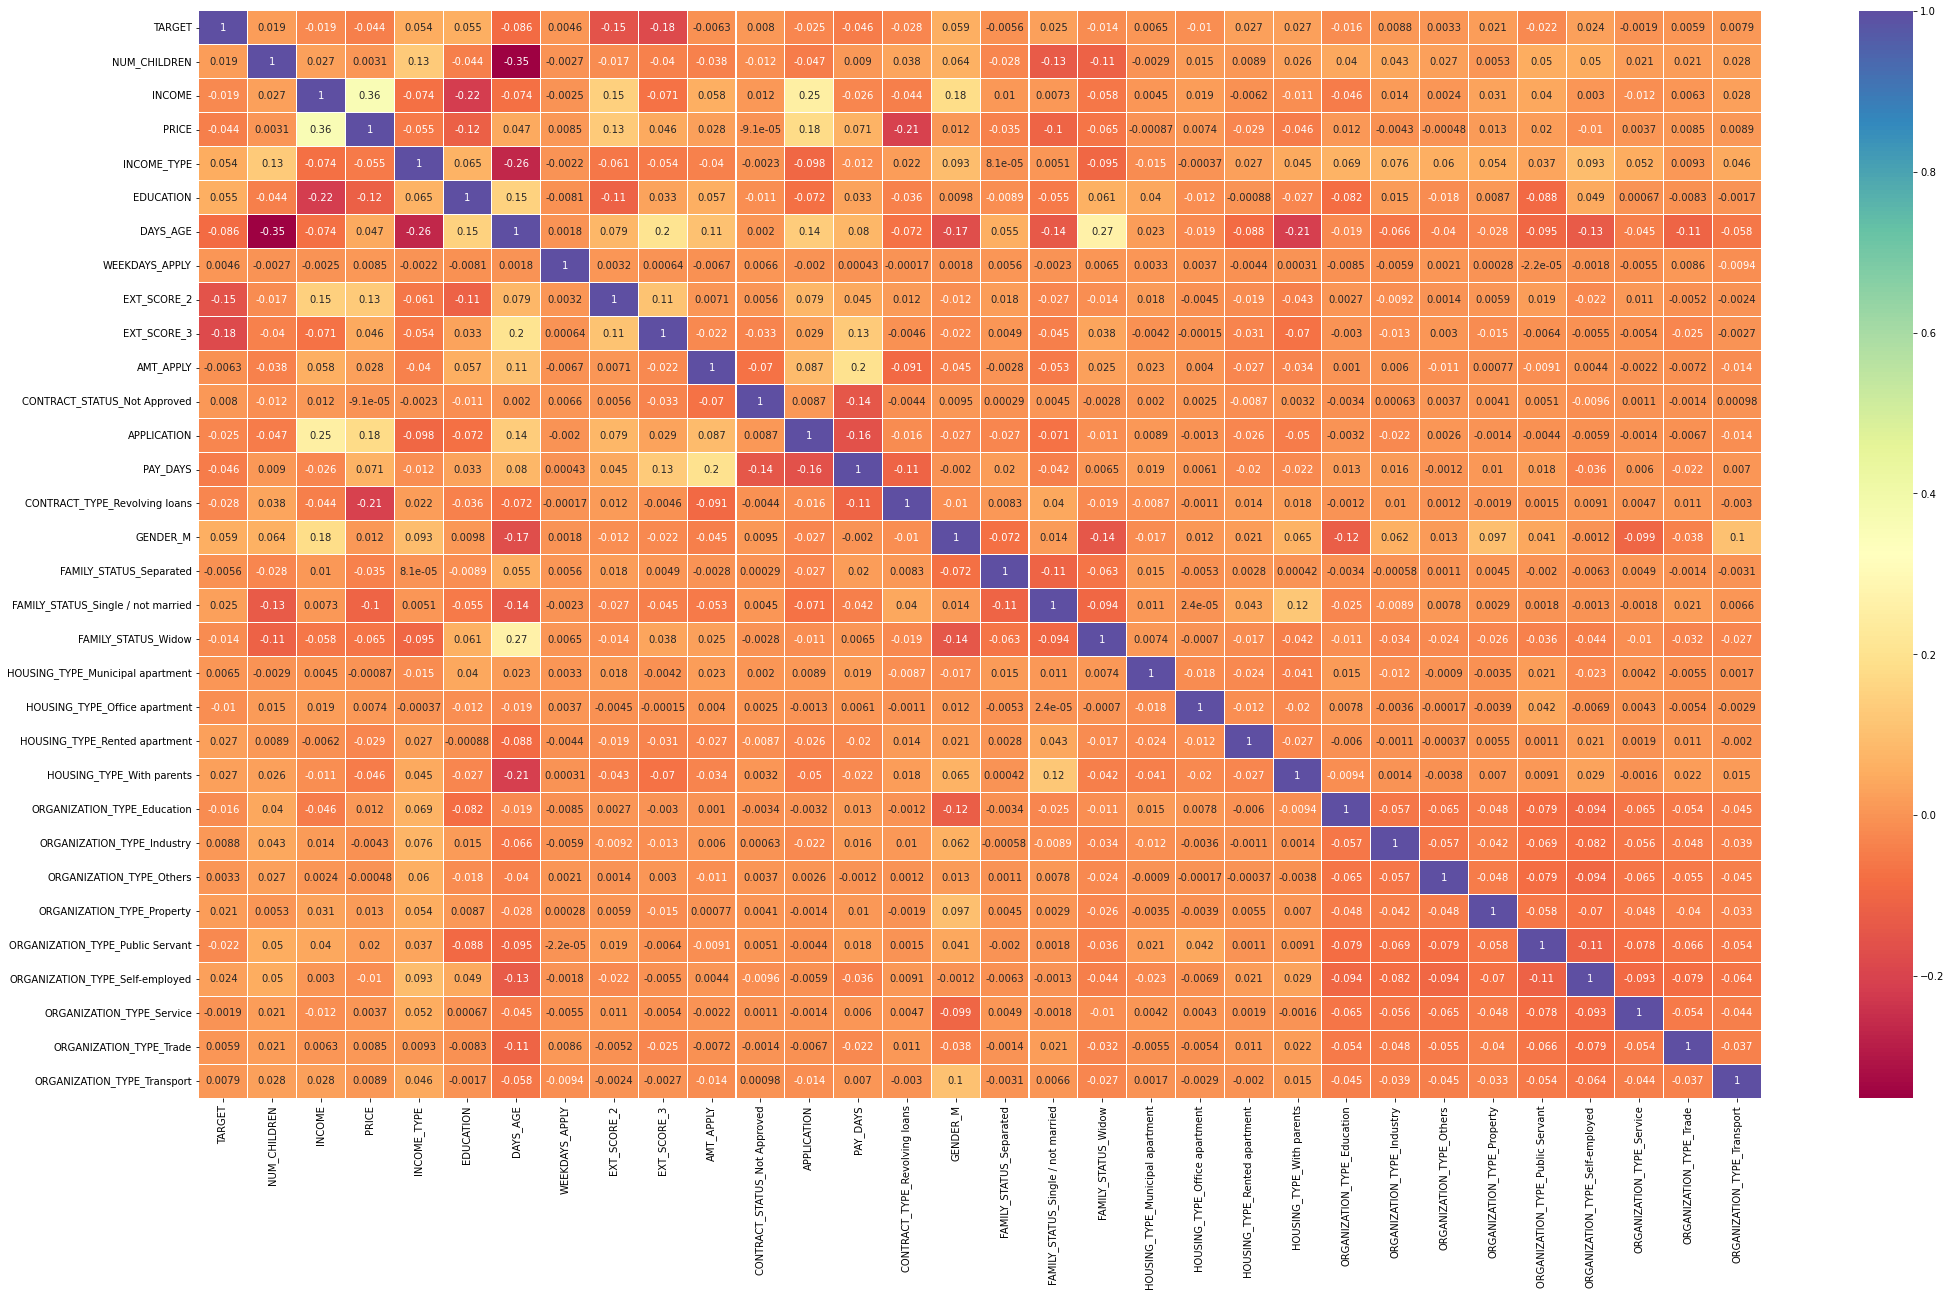

In [55]:
plt.figure(figsize=(35, 20))
sns.heatmap(filtered_coll.corr(), annot=True, linewidths=0.1, cmap=sns.color_palette("Spectral", as_cmap=True), )
plt.show()

### Insight:

As we see, our target value doesn't has specific features which have high correlation to it and we have clear all features which probably will be redundant. So for now this all features that will be used for modilling.

### 3.3.6 Handling Imbalance Data

Before we handle imbalance data, we need to divide `Features table` (X) and `Target Table` (y)

In [56]:
X_train = filtered_coll.drop(columns=['TARGET'])
y_train = filtered_coll['TARGET']

In [57]:
smt = SMOTETomek(random_state = 42)
over = SMOTE()
X_train, y_train = over.fit_resample(X_train, y_train)
y_train.value_counts()

1    42799
0    42799
Name: TARGET, dtype: int64

### 3.3.7 Feature Scalling

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [59]:
X_train_scaled.shape, y_train.shape

((85598, 31), (85598,))

### 3.3.7 Feature Engineering for Data Test

In [60]:
df_test = main_data_test.copy()
df_test.head()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
0,102590,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,Secondary / secondary special,Married,House / apartment,-17598,-2650,-1411.0,-1131,SATURDAY,7,Business Entity Type 3,NaN,0.145475,0.651260
1,35895,141577,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,Higher education,Married,Office apartment,-14097,-7408,-7908.0,-4872,MONDAY,14,Kindergarten,NaN,0.682675,NaN
2,69154,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,Secondary / secondary special,Married,House / apartment,-18384,-2826,-8226.0,-1930,SATURDAY,12,Self-employed,0.814700,0.686312,0.758393
3,222185,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,Secondary / secondary special,Married,House / apartment,-12170,-926,-916.0,-4048,THURSDAY,13,Other,0.399219,0.266520,0.058826
4,147680,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,Incomplete higher,Married,House / apartment,-10790,-577,-4640.0,-2035,MONDAY,14,Business Entity Type 3,0.368452,0.610483,0.392774


#### Handle Missing Values

Same like we did on **train data**, all missing values would be drop except `EXT_SCORE_1` since it'll be the only one I'm gonna drop because it has too many missing values

In [61]:
df_test = df_test.dropna(subset=['PRICE', 'EXT_SCORE_2', 'EXT_SCORE_3'])
df_test = df_test.drop(columns='EXT_SCORE_1')

In [62]:
df_test.isnull().sum()

Unnamed: 0           0
LN_ID                0
TARGET               0
CONTRACT_TYPE        0
GENDER               0
NUM_CHILDREN         0
INCOME               0
APPROVED_CREDIT      0
ANNUITY              0
PRICE                0
INCOME_TYPE          0
EDUCATION            0
FAMILY_STATUS        0
HOUSING_TYPE         0
DAYS_AGE             0
DAYS_WORK            0
DAYS_REGISTRATION    0
DAYS_ID_CHANGE       0
WEEKDAYS_APPLY       0
HOUR_APPLY           0
ORGANIZATION_TYPE    0
EXT_SCORE_2          0
EXT_SCORE_3          0
dtype: int64

#### Edit some values

In [63]:
df_test['FAMILY_STATUS'] = df_test['FAMILY_STATUS'].replace('Civil marriage', 'Married')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(Public_servant, 'Public Servant')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(Education, 'Education')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(Business, 'Business')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(Industry, 'Industry')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(Trade, 'Trade')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(Transport, 'Transport')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(Property, 'Property')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(Service, 'Service')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(Other, 'Others')
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace('NA1', 'Unemployment')

#### Merge with 2nd table

In [64]:
merged_test = pd.merge(df_test, grouped, how='left', on='LN_ID')
merged_test.head()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_2,EXT_SCORE_3,SK_ID_PREV,CONTRACT_STATUS_Not Approved,APPLICATION,INST_DAYS,PAY_DAYS
0,102590,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,Secondary / secondary special,Married,House / apartment,-17598,-2650,-1411.0,-1131,SATURDAY,7,Business,0.145475,0.651260,25.0,0.0,51717.0,4.0,4.0
1,69154,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,Secondary / secondary special,Married,House / apartment,-18384,-2826,-8226.0,-1930,SATURDAY,12,Self-employed,0.686312,0.758393,81.0,0.0,110809.0,3.0,4.0
2,222185,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,Secondary / secondary special,Married,House / apartment,-12170,-926,-916.0,-4048,THURSDAY,13,Others,0.266520,0.058826,23.0,0.0,27980.0,1.0,1.0
3,147680,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,Incomplete higher,Married,House / apartment,-10790,-577,-4640.0,-2035,MONDAY,14,Business,0.610483,0.392774,38.0,0.0,45851.0,2.0,2.0
4,237174,374711,0,Cash loans,F,0,58500.0,135000.0,7321.5,135000.0,Working,Secondary / secondary special,Single / not married,With parents,-10942,-3100,-3232.0,-3576,TUESDAY,10,Public Servant,0.067371,0.199771,131.0,0.0,12716.0,3.0,4.0


#### Encoding

In [65]:
Nom_cat = ['CONTRACT_TYPE', 'GENDER', 'FAMILY_STATUS', 'HOUSING_TYPE', 'ORGANIZATION_TYPE']
Ord_cat = ['INCOME_TYPE', 'EDUCATION', 'WEEKDAYS_APPLY']

In [66]:
df_test_enc = merged_test.copy()

df_test_enc = pd.get_dummies(df_test_enc, columns = Nom_cat, drop_first=True)

for i in Ord_cat:
    df_test_enc[i] = le.fit_transform(df_test_enc[i])
    

In [67]:
df_test_enc = df_test_enc.dropna()
df_test_enc = df_test_enc.drop(columns = ['Unnamed: 0', 'LN_ID'])
df_test_enc

,TARGET,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,EXT_SCORE_2,EXT_SCORE_3,SK_ID_PREV,CONTRACT_STATUS_Not Approved,APPLICATION,INST_DAYS,PAY_DAYS,CONTRACT_TYPE_Revolving loans,GENDER_M,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Widow,HOUSING_TYPE_House / apartment,HOUSING_TYPE_Municipal apartment,HOUSING_TYPE_Office apartment,HOUSING_TYPE_Rented apartment,HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Others,ORGANIZATION_TYPE_Property,ORGANIZATION_TYPE_Public Servant,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Service,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_Unemployment
0,0,3,135000.0,871029.0,44604.0,765000.0,4,4,-17598,-2650,-1411.0,-1131,2,7,0.145475,0.651260,25.0,0.0,51717.0,4.0,4.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,90000.0,247500.0,8887.5,247500.0,4,4,-18384,-2826,-8226.0,-1930,2,12,0.686312,0.758393,81.0,0.0,110809.0,3.0,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,2,112500.0,506889.0,24781.5,418500.0,4,4,-12170,-926,-916.0,-4048,4,13,0.266520,0.058826,23.0,0.0,27980.0,1.0,1.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,216000.0,450000.0,21888.0,450000.0,4,2,-10790,-577,-4640.0,-2035,1,14,0.610483,0.392774,38.0,0.0,45851.0,2.0,2.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,58500.0,135000.0,7321.5,135000.0,4,4,-10942,-3100,-3232.0,-3576,5,10,0.067371,0.199771,131.0,0.0,12716.0,3.0,4.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11808,0,1,67500.0,112500.0,7317.0,112500.0,4,4,-12866,-3154,-1251.0,-4395,5,10,0.399628,0.586740,41.0,0.0,42220.0,2.0,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
11809,1,1,135000.0,313438.5,21073.5,283500.0,4,4,-11421,-3962,-5247.0,-3795,2,7,0.610758,0.368969,26.0,0.0,80289.0,3.0,3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
11810,0,0,157500.0,1078200.0,31522.5,900000.0,2,1,-13313,-2258,-3899.0,-4515,1,12,0.639824,0.782608,68.0,0.0,282506.0,3.0,4.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11811,0,0,216000.0,272520.0,21658.5,225000.0,1,4,-24085,365243,-9354.0,-4740,4,15,0.642139,0.584990,21.0,0.0,70338.0,7.0,7.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Feature Selection

In [68]:
filtered_test = df_test_enc.drop(columns= ['APPROVED_CREDIT', 'ANNUITY', 'DAYS_WORK','ORGANIZATION_TYPE_Unemployment', 
                                  'HOUSING_TYPE_House / apartment', 'ANNUITY', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 
                                  'HOUR_APPLY', 'INST_DAYS'])

In [69]:
filtered_test = filtered_test.rename(columns={'SK_ID_PREV' : 'AMT_APPLY'})
filtered_test.head()

,TARGET,NUM_CHILDREN,INCOME,PRICE,INCOME_TYPE,EDUCATION,DAYS_AGE,WEEKDAYS_APPLY,EXT_SCORE_2,EXT_SCORE_3,AMT_APPLY,CONTRACT_STATUS_Not Approved,APPLICATION,PAY_DAYS,CONTRACT_TYPE_Revolving loans,GENDER_M,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Widow,HOUSING_TYPE_Municipal apartment,HOUSING_TYPE_Office apartment,HOUSING_TYPE_Rented apartment,HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Others,ORGANIZATION_TYPE_Property,ORGANIZATION_TYPE_Public Servant,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Service,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport
0,0,3,135000.0,765000.0,4,4,-17598,2,0.145475,0.651260,25.0,0.0,51717.0,4.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,90000.0,247500.0,4,4,-18384,2,0.686312,0.758393,81.0,0.0,110809.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,2,112500.0,418500.0,4,4,-12170,4,0.266520,0.058826,23.0,0.0,27980.0,1.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,216000.0,450000.0,4,2,-10790,1,0.610483,0.392774,38.0,0.0,45851.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,58500.0,135000.0,4,4,-10942,5,0.067371,0.199771,131.0,0.0,12716.0,4.0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [70]:
filtered_test['TARGET'].value_counts()

0    10294
1      890
Name: TARGET, dtype: int64

#### Handling Imbalance Data

In [71]:
X_test = filtered_test.drop(columns=['TARGET'])
y_test = filtered_test['TARGET']

In [72]:
# X_test, y_test = smt.fit_resample(X_test, y_test)
y_test.value_counts()

0    10294
1      890
Name: TARGET, dtype: int64

#### Feature Scalling

In [73]:
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled.shape, y_test.shape

((11184, 31), (11184,))

Now we have same data for perform modeling

## 4. Modelling

### 4.1 Initiate the model

Since the data that we gonna predict are **classification case**, so we need to call model ML which will work for that:

- Support Vector Classification
- Logistic Regression
- K-NN Classifier
- Decission Tree
- Random Forest
- Naive Bayes

In [74]:
classifier = {
    'svc_clf' : SVC(),
    'log_clf' : LogisticRegression(max_iter = 1000),
    'knn_clf' : KNeighborsClassifier(),
    'dct_clf' : DecisionTreeClassifier(),
    'gnb_clf' : GaussianNB(),
    'rnf_clf' : RandomForestClassifier(),
    'xgb_clf' : XGBClassifier()
}

### 4.2 Choose Best algorithm

Before we choose best model, we need to choose which metrics do we want to use for evaluate our model performance.

Since I know this on this case that `TARGET` table are **Imbalance** it means we **can't use Accuracy** to evaluate, instead I'm gonna use **Precission**
> It's more important to know which debtors who **actually not paid** but our prediction are the opposite of it, and we want to eliminate this value from our model

In [75]:
# result = pd.DataFrame(columns=['Classifier', 'Train Acc', 'Test Acc', 'Precission'])

# for name, model in classifier.items():
    
#     model.fit(X_train_scaled, y_train)
#     data_train = model.predict(X_train_scaled)
#     prediction = model.predict(X_test_scaled)
#     cv_result = cross_validate(model, X_train_scaled, y_train, cv= 5, 
#                                scoring = (['accuracy', 'precision']), return_train_score = True)
    
#     result = result.append({
#         'Classifier' : name,
#         'Train Acc' : cv_result['train_accuracy'].mean(),
#         'Test Acc' : cv_result['test_accuracy'].mean(),
#         'Precission' : cv_result['test_precision'].mean()
# #         'Train Acc' : accuracy_score(y_train, data_train).round(3),
# #         'Test Acc' : accuracy_score(y_test, prediction).round(3),
# #         'Precission' : precision_score(y_test, prediction).round(3)
#     }, ignore_index = True)

# result

In [76]:
# plt.figure(figsize=(10, 5))
# sns.barplot(data= result.sort_values('Test Acc', ascending=False), y='Classifier', x='Test Acc')
# plt.show()

So as you can see, `XGBoost Classifier` have almost ideal accuracy which is **0.9358**. 

Cell above runs at more than 1.5 hours, so I just gonna go **GridsearchCV** for best modeli which is `XGBoost`

In [77]:
boost_hyper = XGBClassifier(learning_rate=0.02)
param = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7]
        }
grid = GridSearchCV(boost_hyper, param_grid= param, cv=5, scoring='accuracy', verbose=2)
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6; total time=   7.8s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child

[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6; total time=   4.7s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6; total time=   4.8s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6; total time=   4.7s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8; total time=   5.1s
[CV] END c

[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.6, gamma=

[CV] END colsample_bytree=0.6, gamma=1, max_depth=7, min_child_weight=1, subsample=0.6; total time=   6.6s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=7, min_child_weight=1, subsample=0.6; total time=   6.6s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=7, min_child_weight=1, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=7, min_child_weight=1, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=7, min_child_weight=1, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=7, min_child_weight=1, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=7, min_child_weight=1, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=7, min_child_weight=1, subsample=1.0; total time=   7.2s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=7, min_child_weight=1, subsample=1.0; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=

[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0; total time=   3.1s
[CV] END c

[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=7, min_child_weight=5, subsample=0.6; total time=   6.6s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=7, min_child_weight=5, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=7, min_child_weight=5, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=7, min_child_weight=5, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=7, min_child_weight=5, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=7, min_child_weight=5, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=7, min_child_weight=5, subsample=1.0; total time=   7.2s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=7, min_child_weight=5, subsample=1.0; total time=   7.2s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=7, min_child_weight=5, subsample=1.0; total time=   7.2s
[CV] END colsample_

[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.6, gamma=

[CV] END colsample_bytree=0.6, gamma=2, max_depth=7, min_child_weight=10, subsample=0.8; total time=   7.0s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=7, min_child_weight=10, subsample=0.8; total time=   7.8s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=7, min_child_weight=10, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=7, min_child_weight=10, subsample=1.0; total time=   7.0s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=7, min_child_weight=10, subsample=1.0; total time=   7.4s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=7, min_child_weight=10, subsample=1.0; total time=   7.3s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=7, min_child_weight=10, subsample=1.0; total time=   7.1s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=7, min_child_weight=10, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=0.6

[CV] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8; total time=   5.6s
[CV] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6; total time=   5.0s
[CV] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6; total time=   5.1s
[CV] END colsample_bytree=0.6, gam

[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.6s
[CV] END colsample_

[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=7, min_child_weight=1, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=7, min_child_weight=1, subsample=0.6; total time=   7.0s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=7, min_child_weight=1, subsample=0.6; total time=   7.0s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=7, min_child_weight=1, subsample=0.6; total time=   7.0s
[CV] END colsample_bytree=0.8, gamma=0.5, max_depth=7, min_child_weight=1, subsample=0.6; total time=   7.1s
[CV] END colsam

[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, 

[CV] END colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=1, subsample=1.0; total time=   7.9s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=5, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=5, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=5, subsample=0.6; total time=   7.0s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=5, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=5, subsample=0.6; total time=   7.0s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=5, subsample=0.8; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=5, subsample=0.8; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=5, subsample=0.8; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=

[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6; total time=   5.3s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8; total time=   5.8s
[CV] END colsample_

[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=7, min_child_weight=10, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=7, min_child_weight=10, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=7, min_child_weight=10, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=7, min_child_weight=10, subsample=0.6; total time=   6.8s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=7, min_child_weight=10, subsample=0.8; total time=   7.6s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=7, min_child_weight=10, subsample=0.8; total time=   7.7s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=7, min_child_weight=10, subsample=0.8; total time=   7.7s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=7, min_child_weight=10, subsample=0.8; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=1.5, max_depth=7, min_child_weight=10, subsample=0.8; total time=   7.8s
[CV] END c

[CV] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.6; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=0.8, gamma=

[CV] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=

[CV] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=0.8, gamma=5, max_depth=7, min_child_weight=1, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=0.8

[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6; total time=   3.7s
[CV] END colsampl

[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=7, min_child_weight=1, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=7, min_child_weight=1, subsample=0.8; total time=   8.4s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=7, min_child_weight=1, subsample=1.0; total time=   8.2s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=7, min_child_weight=1, subsample=1.0; total time=   8.4s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=7, min_child_weight=1, subsample=1.0; total time=   8.3s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=7, min_child_weight=1, subsample=1.0; total time=   8.4s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=7, min_child_weight=1, subsample=1.0; total time=   8.3s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=7, min_child_weight=5, subsample=0.6; total time=   7.4s
[CV] END colsample_bytree=1.0, gamma=0.5, max_depth=7, min_child_weight=5, subsample=0.6; total time=   7.4s
[CV] END colsample_

[CV] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6; total time=   5.3s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6; total time=   5.4s
[CV] END colsample_bytree=1.0, 

[CV] END colsample_bytree=1.0, gamma=1, max_depth=7, min_child_weight=5, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=7, min_child_weight=5, subsample=1.0; total time=   7.9s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=7, min_child_weight=5, subsample=1.0; total time=   7.9s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=7, min_child_weight=5, subsample=1.0; total time=   8.1s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=7, min_child_weight=10, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=7, min_child_weight=10, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=7, min_child_weight=10, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=7, min_child_weight=10, subsample=0.6; total time=   7.1s
[CV] END colsample_bytree=1.0, gamma=1, max_depth=7, min_child_weight=10, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=1.0, g

[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6; total time=   5.1s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8; total time=   5.6s
[CV] END colsample_

[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=7, min_child_weight=10, subsample=1.0; total time=   8.1s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=7, min_child_weight=10, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=1.0, gamma=1.5, max_depth=7, min_child_weight=10, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=1, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=1, subsample=0.6; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=1, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=1, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=1, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=1.

[CV] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=5, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.6; total time=   5.3s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.6; total time=   5.3s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.6; total time=   5.3s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.6; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.6; total time=   6.0s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=1.0

[CV] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=1.0, gamma=

[CV] END colsample_bytree=1.0, gamma=5, max_depth=7, min_child_weight=1, subsample=0.6; total time=   7.5s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=7, min_child_weight=1, subsample=0.6; total time=   7.3s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=7, min_child_weight=1, subsample=0.8; total time=   8.0s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=7, min_child_weight=1, subsample=0.8; total time=   8.4s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=7, min_child_weight=1, subsample=0.8; total time=   8.4s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=7, min_child_weight=1, subsample=0.8; total time=   8.2s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=7, min_child_weight=1, subsample=0.8; total time=   8.1s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=7, min_child_weight=1, subsample=1.0; total time=   8.1s
[CV] END colsample_bytree=1.0, gamma=5, max_depth=7, min_child_weight=1, subsample=1.0; total time=   9.0s
[CV] END colsample_bytree=1.0, gamma=

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [78]:
print("Best hyperparameter:", grid.best_params_)

Best hyperparameter: {'colsample_bytree': 0.6, 'gamma': 2, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0}


In [79]:
final = grid.predict(X_test_scaled)
print("Accuracy for predict who are eligble for apply a loan:", accuracy_score(y_test, final).round(3))

Accuracy for predict who are eligble for apply a loan: 0.268


In [80]:
print('And this is the full metrics report for our model')
print(classification_report(y_test, final))

And this is the full metrics report for our model
              precision    recall  f1-score   support

           0       0.96      0.21      0.35     10294
           1       0.09      0.91      0.16       890

    accuracy                           0.27     11184
   macro avg       0.53      0.56      0.26     11184
weighted avg       0.89      0.27      0.33     11184



You can see the documentation/pict of **cross_validate** up there, if that cell run prefectly it will give better result, but since it takes time to run (in my case approximately 2hrs) This is the result that I show for now. If you can run it properly, I guarantee it will shown like my documentation that I gave

----------------------------------------------------------

### Best features

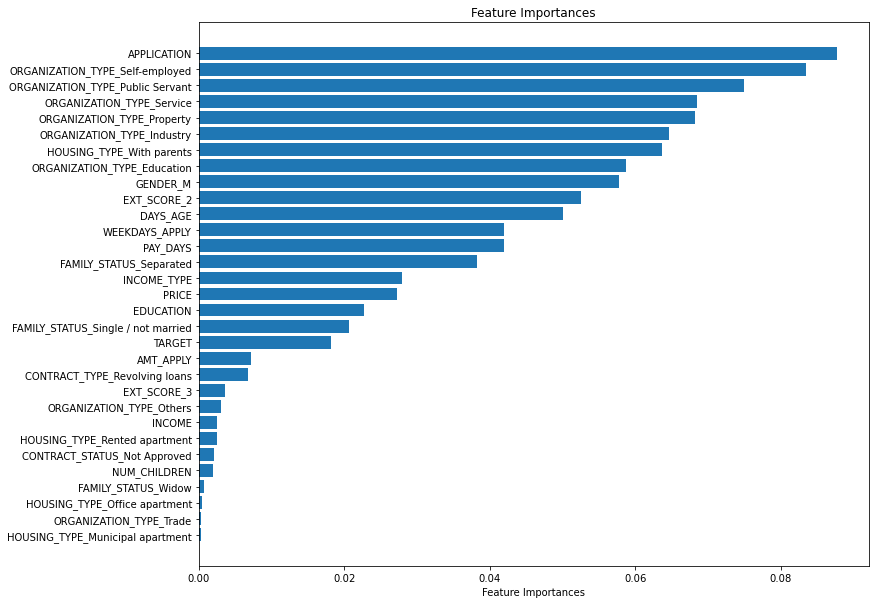

In [84]:
plt.figure(figsize=(12, 10))
boost_hyper.fit(X_train_scaled, y_train)
sort = boost_hyper.feature_importances_.argsort()

plt.barh(filtered_coll.columns[sort], boost_hyper.feature_importances_[sort])
plt.xlabel("Feature Importances")
plt.title('Feature Importances')
plt.show()